## **Project - Machine Learning & Computational Statistics**

This notebook includes the implementation of both components of the project for the Machine Learning and Computational Statistics course

### **Part 1 - Spectral Unmixing**

Import some packages

In [4]:
# Importing some required packages

import scipy.io as sio
import numpy as np
from scipy.optimize import minimize, nnls
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
# import warnings
from pysptools.abundance_maps.amaps import FCLS

# Ignoring all warnings
# warnings.simplefilter("ignore")

Load and transform the data 

In [6]:
# Loading the Salina's hyperspectral image
hsi = sio.loadmat("Salinas_cube.mat")
hsi = hsi["salinas_cube"]

# Getting the shape of hsi
hsi_shape = hsi.shape

# Reshaping
hsi = hsi.reshape(hsi_shape[0] * hsi_shape[1], hsi_shape[2])

# Loading the spectral signatures of the endmembers
endmembers = sio.loadmat("Salinas_endmembers.mat")
endmembers = endmembers["salinas_endmembers"]

# Loading the labels of the pixels
pixels_labels = sio.loadmat("Salinas_gt.mat")
pixels_labels = pixels_labels["salinas_gt"]

# Getting the shape of pixels_labels
pixels_labels_shape = pixels_labels.shape

# Reshaping
pixels_labels = pixels_labels.reshape(pixels_labels_shape[0] * pixels_labels_shape[1])

Keep only the pixels with nonzero class label

In [7]:
# Getting the pixels with nonzero class label
hsi_non_zero = hsi[pixels_labels != 0]

# Getting the corresponding amount
total_non_zero_pixels = hsi_non_zero.shape[0]

# Getting the multiplication of the first two dimensions
initial_two_dim = hsi_shape[0] * hsi_shape[1]

**1. Estimation of the abundance vector of each pixel (abundance maps) using the Least Squares criterion without any constraint**

Define a method for computing the abundance vectors for each pixel and the abundance map of each material using the Least Squares criterion without imposing any constraint

In [8]:
def unmix_ls_no_constraint(
    hyper_image, endmembers, initial_two_dim, total_non_zero_pixels, pixels_labels
):
    """
    This function is used to estimate the abundance vector using the Least Squares
    method without imposing any constraint.

    :param hyper_image: All the pixels of the hyperspectral image
    :param endmembers: The endmembers matrix
    :param initial_two_dim: The multiplication of first two dimensions
    :param total_non_zero_pixels: The total pixels with non zero label
    :param pixels_labels: The labels of the pixels
    :return: The estimated abundance matrix and the reconstruction error across all pixels
    """

    # Initializing the variables to store the abundances and the error
    abundances = np.zeros((initial_two_dim, 7))
    error = 0

    # Iterating over all pixels
    for index, signature in enumerate(hyper_image):

        # Getting the abundance vector of the current pixel
        abundance_vector = np.linalg.lstsq(endmembers, signature, rcond=None)[0]

        # Getting the initial index of the pixel in the hyperspectral image
        initial_index = np.where(pixels_labels != 0)[0][index]

        # Storing
        abundances[initial_index, :] = abundance_vector

        # Computing the estimated signature of the current pixel
        estimated_signature = endmembers @ abundance_vector

        # Computing the reconstruction error
        error += np.linalg.norm(signature - estimated_signature) ** 2

    # Getting the average reconstruction error
    reconstruction_error = error / total_non_zero_pixels

    return abundances, reconstruction_error

Define a method to visualize the abundance maps of the endmembers

In [10]:
def visualize_abundance_maps(abundances, shape_0, shape_1):
    """
    This function used to display the abundance maps of the endmembers

    :param abundances: The matrix containing all the abundance maps
    :param shape_0: The first dimension of the hyperspectral image
    :param shape_1: The second dimension of the hyperspectral image
    :return: None
    """

    # Creating the figure and the subplots
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))

    # Iterating over the endmembers
    for endmember in range(7):

        # Determining row and column for the current subplot
        row, col = divmod(endmember, 4)

        # Getting the axis
        ax = axes[row, col]

        # Setting the title of the subplot
        ax.set_title(f"Endmember {endmember + 1}")

        # Displaying
        ax.imshow(abundances[:, endmember].reshape((shape_0, shape_1)), cmap="viridis")

        # Setting the labels
        ax.set_xlabel("Width")
        ax.set_ylabel("Height")

    # Hiding the unused subplot
    axes[1, 3].axis("off")

    # Adding an overall title
    fig.suptitle("Abundance Maps of Endmembers", fontsize=16)

    # Showing
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

Compute the abundance maps and the reconstruction error

In [11]:
# Computing the abundance maps and the reconstruction error
abundances_1, reconstruction_error_1 = unmix_ls_no_constraint(
    hsi_non_zero, endmembers, initial_two_dim, total_non_zero_pixels, pixels_labels
)

Each column of the array corresponds to the abundance map of each material. Below is a sample of the values of the abundance map of the first material

In [12]:
abundances_1[:, 0]

array([0., 0., 0., ..., 0., 0., 0.])

The reconstruction error of this unmixing method is illustrated below

In [13]:
print("The reconstruction error of this method is:", reconstruction_error_1.round(4))

The reconstruction error of this method is: 35058.8807


Show the abundance maps of all the endmembers

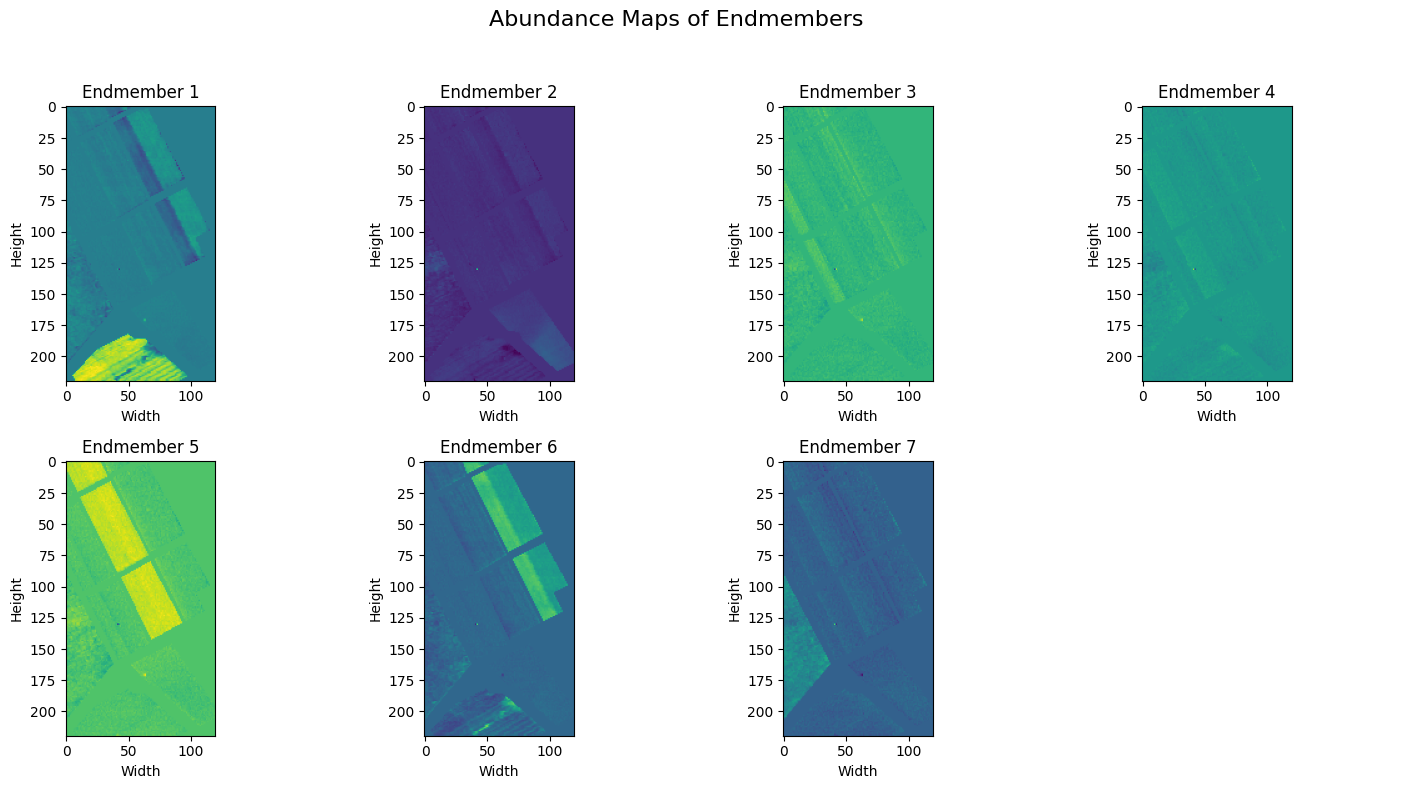

In [14]:
# Visualizing the abundance maps
visualize_abundance_maps(abundances_1, hsi_shape[0], hsi_shape[1])

**2. Estimation of the abundance vector of each pixel (abundance maps) using the Least Squares criterion and by imposing the sum-to-one constraint**

Define a function for estimating the abundance vector for a pixel of the hyperspectral image using the Least Squares criterion and by imposing the sum-to-one constraint

In [15]:
def unmix_ls_sum_to_one(signature, endmembers):
    """
    This function used to estimate the abundance vector of one pixel using
    the Least Squares method and by imposing the sum-to-one constraint.

    :param signature: The signature of the pixel
    :param endmembers: The endmembers matrix
    :return: The estimated abundance vector
    """

    # Setting the objective function to minimize
    def objective(abundance_vector):
        return np.linalg.norm(signature - endmembers @ abundance_vector) ** 2

    # Setting the sum-to-one constraint
    constraints = [{"type": "eq", "fun": lambda theta: np.sum(theta) - 1}]

    # Setting the initial abundance vector
    initial_abundance_vector = np.ones(7) / 7

    # Estimating
    estimation = minimize(
        objective, initial_abundance_vector, constraints=constraints, method="SLSQP"
    )

    return estimation.x

Define a function to apply the above unmixing method for all the pixels of the hyperspectral image

In [16]:
def apply_unmix_ls_sum_to_one(
    hyper_image, endmembers, initial_two_dim, total_non_zero_pixels, pixels_labels
):
    """
    This function is used to apply the Least Squares criterion with the sum-to-one
    constraint to estimate the abundance vectors of all the pixels.

    :param hyper_image: Thy huperspectral image
    :param endmembers: The endmembers
    :param initial_two_dim: The multiplication of first two dimensions
    :param total_non_zero_pixels: The total pixels with non zero label
    :param pixels_labels: The labels of the pixels
    :return: The estimated abundance matrix and the reconstruction error across all pixels
    """

    # Initializing the variables to store the abundances and the error
    abundances = np.zeros((initial_two_dim, 7))
    error = 0

    # Iterating over all pixels
    for index, signature in enumerate(hyper_image):

        # Estimating the abundance vector of the current pixel
        abundance_vector = unmix_ls_sum_to_one(signature, endmembers)

        # Getting the initial index of the pixel in the hyperspectral image
        initial_index = np.where(pixels_labels != 0)[0][index]

        # Storing
        abundances[initial_index, :] = abundance_vector

        # Computing the estimated signature
        estimated_signature = endmembers @ abundance_vector

        # Computing the reconstruction error
        error += np.linalg.norm(signature - estimated_signature) ** 2

    # Getting the average reconstruction error
    reconstruction_error = error / total_non_zero_pixels

    return abundances, reconstruction_error

Compute the abundance maps and the reconstruction error

In [17]:
# Computing the abundance maps and the reconstruction error
abundances_2, reconstruction_error_2 = apply_unmix_ls_sum_to_one(
    hsi_non_zero, endmembers, initial_two_dim, total_non_zero_pixels, pixels_labels
)

Each column of the array corresponds to the abundance map of each material. Below is a sample of the values of the abundance map of the first material

In [18]:
abundances_2[:, 0]

array([0., 0., 0., ..., 0., 0., 0.])

The reconstruction error of this unmixing method is illustrated below

In [19]:
print("The reconstruction error of this method is:", reconstruction_error_2.round(4))

The reconstruction error of this method is: 43082.5763


Show the abundance maps of all the endmembers

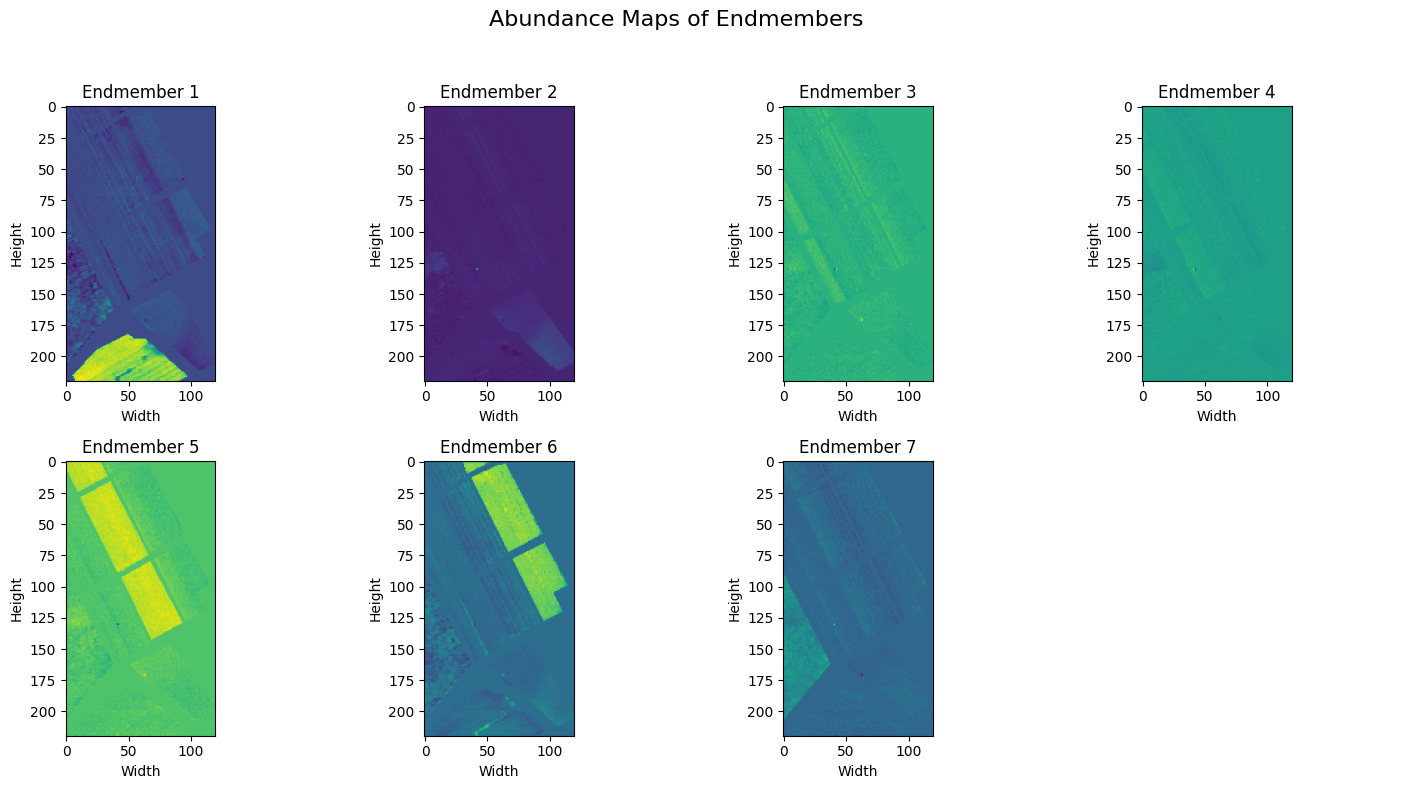

In [20]:
# Visualizing the abundance maps
visualize_abundance_maps(abundances_2, hsi_shape[0], hsi_shape[1])

**3. Estimation of the abundance vector of each pixel (abundance maps) using the Least Squares criterion by imposing the non-negativity constraint**

Define a method for computing the abundance vectors for each pixel and the abundance map of each material using the Least Squares criterion and by imposing the non-negativity constraint

In [21]:
def unmix_ls_non_negativity(
    hyper_image, endmembers, initial_two_dim, total_non_zero_pixels, pixels_labels
):
    """
    This function is used to estimate the abundance vector using the Least Squares
    method without imposing any constraint.

    :param hyper_image: All the pixels of the hyperspectral image
    :param endmembers: The endmembers
    :param initial_two_dim: The multiplication of first two dimensions
    :param total_non_zero_pixels: The total pixels with non zero label
    :param pixels_labels: The labels of the pixels
    :return: The estimated abundance matrix and the reconstruction error across all pixels
    """

    # Initializing the variables to store the abundances and the error
    abundances = np.zeros((initial_two_dim, 7))
    error = 0

    # Iterating over all pixels
    for index, signature in enumerate(hyper_image):

        # Getting the abundance vector of the current pixel
        abundance_vector, _ = nnls(endmembers, signature)

        # Getting the initial index of the pixel in the hyperspectral image
        initial_index = np.where(pixels_labels != 0)[0][index]

        # Storing
        abundances[initial_index, :] = abundance_vector

        # Computing the estimated signature of the current pixel
        estimated_signature = endmembers @ abundance_vector

        # Computing the reconstruction error
        error += np.linalg.norm(signature - estimated_signature) ** 2

    # Getting the average reconstruction error
    reconstruction_error = error / total_non_zero_pixels

    return abundances, reconstruction_error

Compute the abundance maps and the reconstruction error

In [22]:
# Computing the abundance maps and the reconstruction error
abundances_3, reconstruction_error_3 = unmix_ls_non_negativity(
    hsi_non_zero, endmembers, initial_two_dim, total_non_zero_pixels, pixels_labels
)

Each column of the array corresponds to the abundance map of each material. Below is a sample of the values of the abundance map of the first material

In [23]:
abundances_3[:, 0]

array([0., 0., 0., ..., 0., 0., 0.])

The reconstruction error of this unmixing method is illustrated below

In [24]:
print("The reconstruction error of this method is:", reconstruction_error_3.round(4))

The reconstruction error of this method is: 156104.1822


Show the abundance maps of all the endmembers

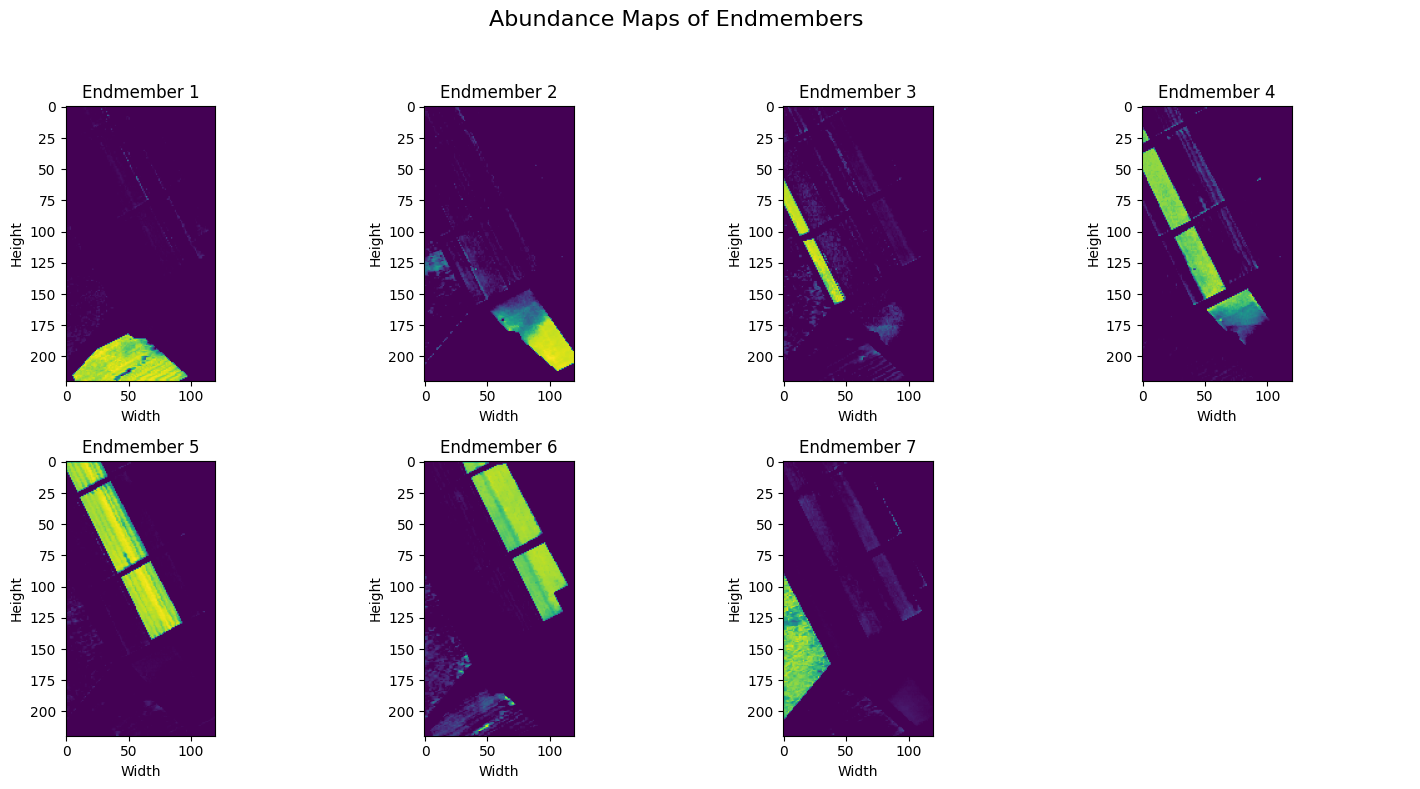

In [25]:
# Visualizing the abundance maps
visualize_abundance_maps(abundances_3, hsi_shape[0], hsi_shape[1])

**4. Estimation of the abundance vector of each pixel (abundance maps) using the Least Squares criterion by imposing the sum-to-one and the non-negativity constraints**

Define a method for computing the abundance vectors for each pixel and the abundance map of each material using the Least Squares criterion and by imposing both constraints

In [26]:
def unmix_ls_both_constraints(
    hyper_image, endmembers, initial_two_dim, total_non_zero_pixels, pixels_labels
):
    """
    This function is used to estimate the abundance vector using the Least Squares
    method without imposing any constraint.

    :param hyper_image: All the pixels of the hyperspectral image
    :param endmembers: The endmembers
    :param initial_two_dim: The multiplication of first two dimensions
    :param total_non_zero_pixels: The total pixels with non zero label
    :param pixels_labels: The labels of the pixels
    :return: The estimated abundance matrix and the reconstruction error across all pixels
    """

    # Initializing the variables to store the abundances and the error
    abundances = np.zeros((initial_two_dim, 7))
    error = 0

    # Iterating over all pixels
    for index, signature in enumerate(hyper_image):

        # Getting the abundance vector of the current pixel
        abundance_vector = FCLS(
            signature.reshape(1, -1).astype(np.double), endmembers.astype(np.double).T
        ).flatten()

        # Getting the initial index of the pixel in the hyperspectral image
        initial_index = np.where(pixels_labels != 0)[0][index]

        # Storing
        abundances[initial_index, :] = abundance_vector

        # Computing the estimated signature of the current pixel
        estimated_signature = endmembers @ abundance_vector

        # Computing the reconstruction error
        error += np.linalg.norm(signature - estimated_signature) ** 2

    # Getting the average reconstruction error
    reconstruction_error = error / total_non_zero_pixels

    return abundances, reconstruction_error

Compute the abundance maps and the reconstruction error

In [27]:
# Computing the abundance maps and the reconstruction error
abundances_4, reconstruction_error_4 = unmix_ls_both_constraints(
    hsi_non_zero, endmembers, initial_two_dim, total_non_zero_pixels, pixels_labels
)

Each column of the array corresponds to the abundance map of each material. Below is a sample of the values of the abundance map of the first material

In [28]:
abundances_4[:, 0]

array([0., 0., 0., ..., 0., 0., 0.])

The reconstruction error of this unmixing method is illustrated below

In [29]:
print("The reconstruction error of this method is:", reconstruction_error_4.round(4))

The reconstruction error of this method is: 738727.0488


Show the abundance maps of all the endmembers

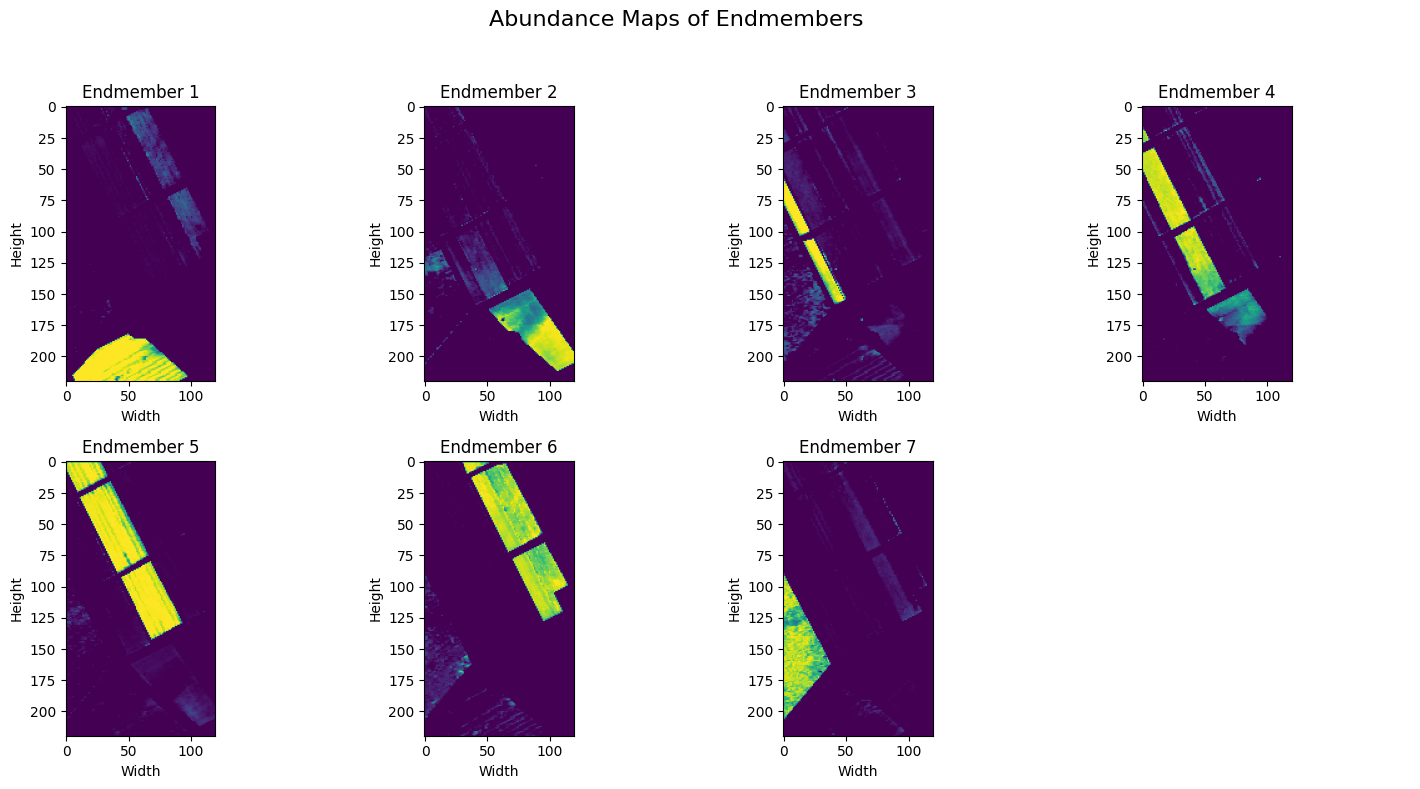

In [30]:
# Visualizing the abundance maps
visualize_abundance_maps(abundances_4, hsi_shape[0], hsi_shape[1])

**5. Estimation of the abundance vector of each pixel (abundance maps) using the LASSO**

Define a function for estimating the abundance vector for a pixel of the hyperspectral image using the LASSO to impose sparcity on the abundance vector

In [31]:
def unmix_lasso(signature, endmembers, lambda_parameter):
    """
    This function used to estimate the abundance vector using LASSO regression
    to impose sparsity on the abundance vector.

    :param signature: The signature of the pixel
    :param endmembers: The endmembers
    :param lambda_parameter: The regularization parameter
    :return: The estimated abundance vector
    """

    # Setting the Lasso model
    lasso_model = Lasso(alpha=lambda_parameter)

    # Fitting the Lasso model
    lasso_model.fit(endmembers, signature)

    return lasso_model.coef_

Define a function to apply the above LASSO unmixing method for all the pixels of the hyperspectral image

In [32]:
def apply_unmix_lasso(
    hyper_image,
    endmembers,
    lambda_parameter,
    initial_two_dim,
    total_non_zero_pixels,
    pixels_labels,
):
    """
    This function is used to apply the LASSO to estimate the abundance vectors of all the pixels.

    :param hyper_image: Thy huperspectral image
    :param endmembers: The endmembers
    :param lambda_parameter: The regularization parameter
    :param initial_two_dim: The multiplication of first two dimensions
    :param total_non_zero_pixels: The total pixels with non zero label
    :param pixels_labels: The labels of the pixels
    :return: The estimated abundance matrix and the reconstruction error across all pixels
    """

    # Initializing the variables to store the abundances and the error
    abundances = np.zeros((initial_two_dim, 7))
    error = 0

    # Iterating over the pixels
    for index, signature in enumerate(hyper_image):

        # Estimating the abundance vector of the current pixel
        abundance_vector = unmix_lasso(signature, endmembers, lambda_parameter)

        # Getting the initial index of the pixel in the hyperspectral image
        initial_index = np.where(pixels_labels != 0)[0][index]

        # Storing
        abundances[initial_index, :] = abundance_vector

        # Computing the estimated signature
        estimated_signature = endmembers @ abundance_vector

        # Computing the reconstruction error
        error += np.linalg.norm(signature - estimated_signature) ** 2

    # Getting the average reconstruction error
    reconstruction_error = error / total_non_zero_pixels

    return abundances, reconstruction_error

Check for different values of the lambda parameter to see which gives smaller reconstruction error

In [33]:
# Initializing a dictionary to store the errors and the abundace maps for different values of lambda parameter
reconstruction_errors = {}
abundance_maps = {}

# Setting the values to check
lambda_parameter_values = [0.01, 0.1, 1, 10, 100, 1000]

# Iterating over the values
for lambda_parameter_value in lambda_parameter_values:

    # Getting the abundance maps and the reconstruction error
    abundances, reconstruction_error = apply_unmix_lasso(
        hsi_non_zero,
        endmembers,
        lambda_parameter_value,
        initial_two_dim,
        total_non_zero_pixels,
        pixels_labels,
    )

    # Storing
    reconstruction_errors[lambda_parameter_value] = reconstruction_error.round(4)
    abundance_maps[lambda_parameter_value] = abundances

    print(
        f"Lambda Parameter: {lambda_parameter_value} -> Reconstruction Error: {reconstruction_error.round(4)}"
    )

Lambda Parameter: 0.01 -> Reconstruction Error: 81926.49
Lambda Parameter: 0.1 -> Reconstruction Error: 81922.3009
Lambda Parameter: 1 -> Reconstruction Error: 81881.0455
Lambda Parameter: 10 -> Reconstruction Error: 81568.701
Lambda Parameter: 100 -> Reconstruction Error: 87285.5914
Lambda Parameter: 1000 -> Reconstruction Error: 148991.14


Visualize the various reconstruction errors

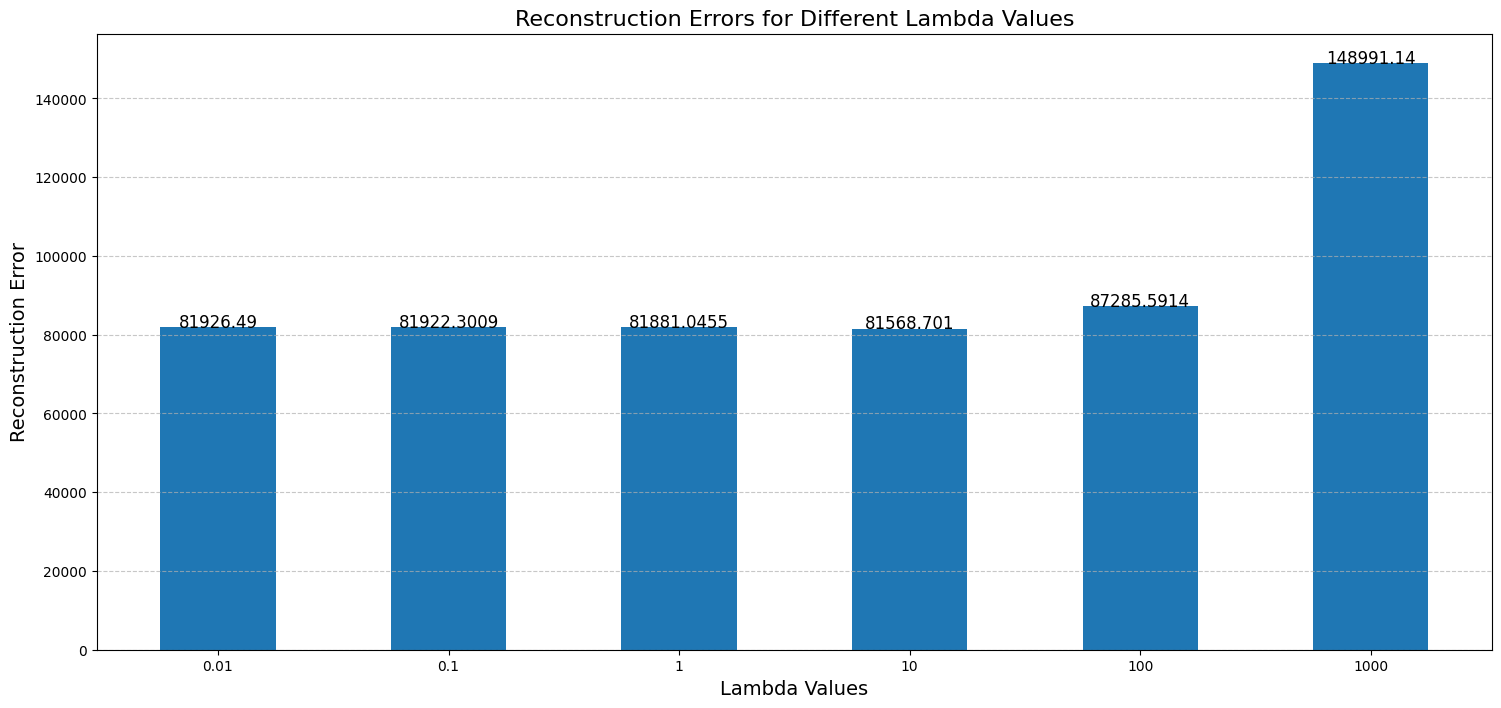

In [34]:
# Setting the positions of the x values
x_positions = np.arange(len(lambda_parameter_values))

# Setting the figure
plt.figure(figsize=(18, 8))

# Creating the bars
bars = plt.bar(x_positions, list(reconstruction_errors.values()), width=0.5)

# Setting some parameters of the bar chart
plt.xlabel("Lambda Values", fontsize=14)
plt.ylabel("Reconstruction Error", fontsize=14)
plt.title("Reconstruction Errors for Different Lambda Values", fontsize=16)
plt.xticks(x_positions, labels=lambda_parameter_values)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Iterating over the bars
for bar in bars:

    # Getting the value of the bar
    height = bar.get_height()

    # Putting the the value on the bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.2,
        f"{height}",
        ha="center",
        fontsize=12,
    )

# Showing the plot
plt.show()

We can observe that the value of 10 for the lambda parameter gives the best and smallest reconstruction error compared to the other values which is 81,568.701. Below, we present the abundance maps of all the endmembers based on the value 10 of the parameter lamda

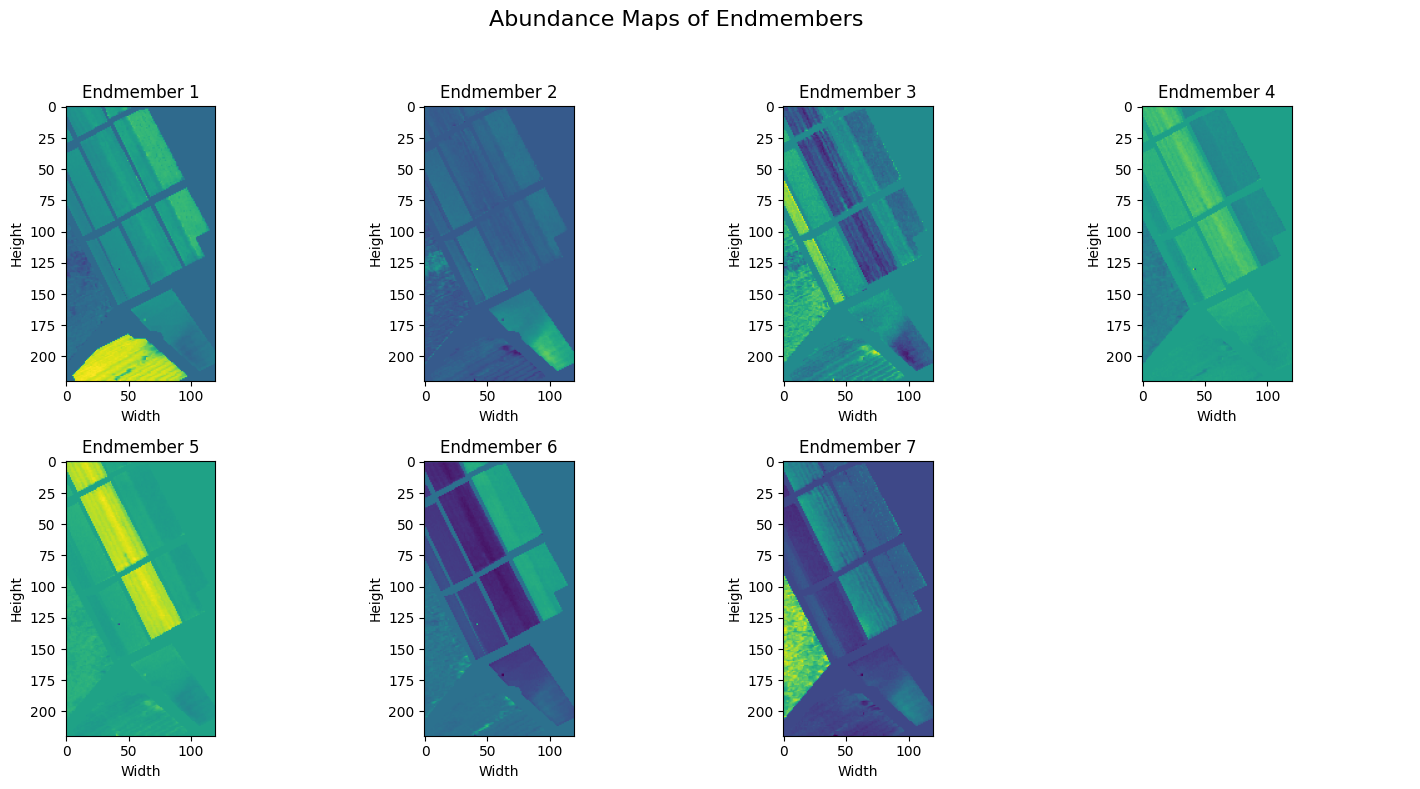

In [35]:
# Visualizing the abundance maps
visualize_abundance_maps(abundance_maps[10], hsi_shape[0], hsi_shape[1])

##### **Conclusion**

<u>Reconstruction Error Results</u>

|Method|Reconstruction Error|
|-------------------|-------------------|
|Least Squares without any Constraint|35,058.8807|
|Least Squares with Sum-to-One Constraint|43,082.5763|
|Least Squares with Non-Negativity Constraint|156,104.1822|
|Least Squares with Both Constraints|738,727.0488|
|LASSO|81,568.701|

**1. Least Squares without any Constraint**

As expected, this method has the lowest reconstruction error because it does not impose any constraints on the abundance vectors.

**2. Least Squares with Sum-to-One Constraint**

This slightly higher error suggests that the sum-to-one constraint limits the solution space, resulting in a small increase in error.

**3. Least Squares with Non-Negativity Constraint**

A significant increase in error compared to unconstrained LS or sum-to-one constrained LS. This may indicate that the non-negativity constraint is restrictive, preventing the optimal solution from being reached. If the data naturally contains negative contributions or zero valued features due to noise, enforcing non-negativity may reduce reconstruction accuracy.

**4. Least Squares with Both Constraints**

The massive increase in reconstruction error suggests that the combined constraints are too restrictive for our dataset. This may again suggest that there is a high level of noise in the image, which is removed by the constraints.

**5. LASSO with 𝜆=10**

The error is higher than unconstrained LS but lower than LS with non-negativity or combined constraints. This indicates that the l1 regularization balances sparsity and reconstruction accuracy well. It is possible that further tuning of λ might reduce the error while maintaining sparsity.

Clearly, the more constraints we have, the smaller the reconstruction error we have. One possible reason for this is that the image contains a lot of noise and when we apply constraints we remove a significant amount of it, resulting in a very high difference between the original and the new spectral signatures of the image.

<u>Abundance Maps Results</u>

To comment on the results of the five methods, we need to display the initial abundance vectors of each label so that we can draw a conclusion

In [37]:
def find_abundance_vectors(pixels_labels, multp_two_dim):
    """
    This function used to find the abundance vectors of the labels

    :param pixels_labels: The labels of the pixels
    :param multp_two_dim: The multiplication of the first two dimensions of the image
    :return: The abundance vectors of the labels
    """

    # Initializing a dictionary to store the vectors og the labels
    initial_abundance_vectors = {}

    # Iterating over the labels
    for label in range(1,8):

        # Getting the indices of the current label
        label_indices = pixels_labels == label

        # Initializing
        abundance_vectors = np.zeros((multp_two_dim))

        # Getting the abundance vector of the current label
        abundance_vectors[label_indices] = pixels_labels[label_indices]

        # Updating
        initial_abundance_vectors[label] = abundance_vectors

    return initial_abundance_vectors

# Finding the abundance vectors
initial_abundance_vectors = find_abundance_vectors(pixels_labels, initial_two_dim)

Visualize the abundance vectors of the labels

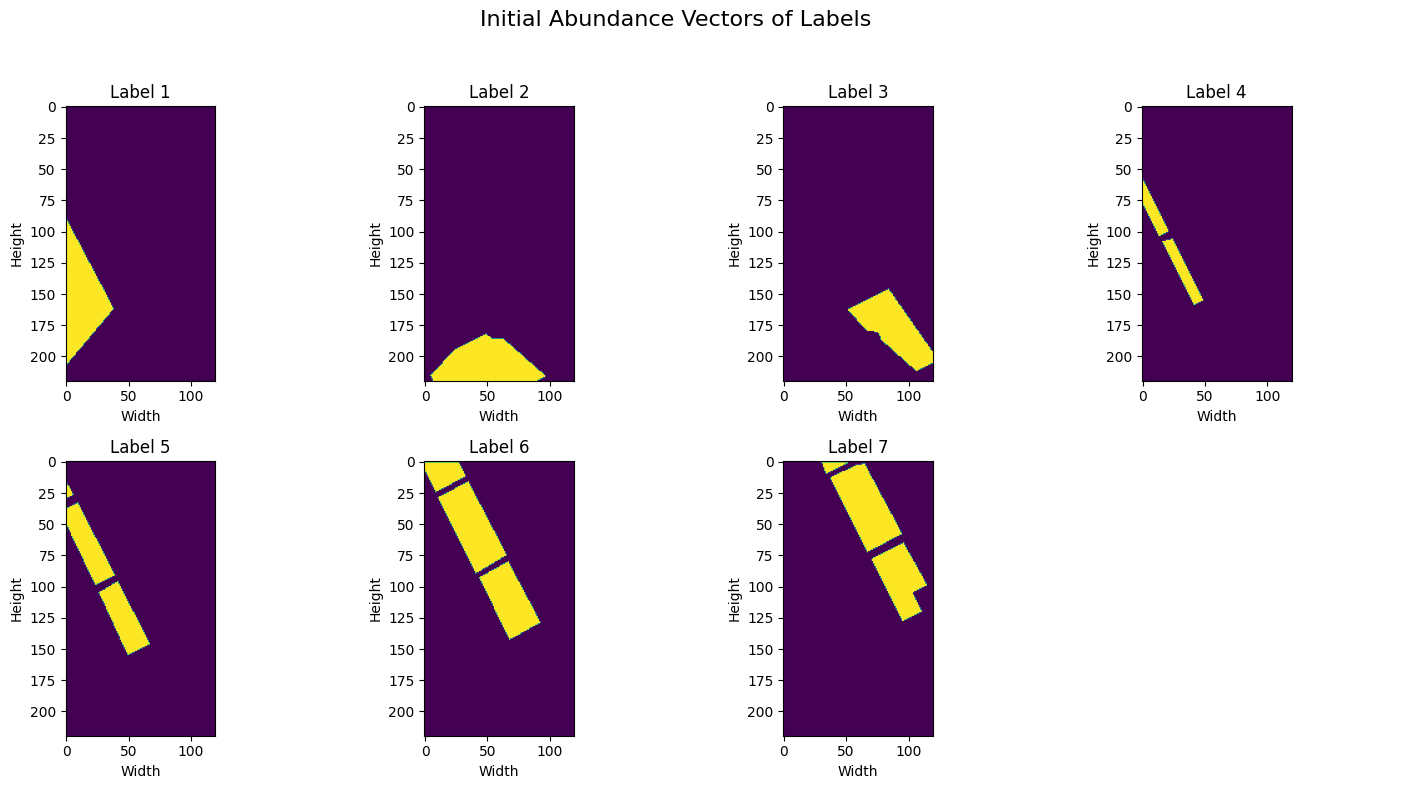

In [38]:
def visualize_abundance_vectors(abundance_vectors):
    """
    This function used to display the abundance vectors of the labels
    
    :param abundance_vectors: Dictionary with all the abundance vectors of the labels
    :return: None
    """    

    # Creating the figure and the subplots
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))

    # Iterating over the endmembers
    for label, abundance_vector in abundance_vectors.items():

        # Determining row and column for the current subplot
        row, col = divmod(label - 1, 4)

        # Getting the axis
        ax = axes[row, col]

        # Setting the title of the subplot
        ax.set_title(f"Label {label}")

        # Displaying
        ax.imshow(abundance_vector.reshape((hsi_shape[0], hsi_shape[1])), cmap="viridis")

        # Setting the labels
        ax.set_xlabel("Width")
        ax.set_ylabel("Height")

    # Hiding the unused subplot
    axes[1, 3].axis("off")

    # Adding an overall title
    fig.suptitle("Initial Abundance Vectors of Labels", fontsize=16)

    # Showing
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Displaying
visualize_abundance_vectors(initial_abundance_vectors)

As we can observe in the figure above and in the images of the abundance maps of the 5 methods, it is clear that the regression models used to separate the labels from the endmembers and it is obvious that the LS with two constraints and the LS with non-negative constraint methods achieve the best separation of the labels and their respective regions with the former being slightly better than the latter.  Although they have a higher reconstruction error rate, they facilitate the understanding of the boundaries between classes.  Unlike the other three methods that do not perform well and do not have clear boundaries and exhibit blurred class separations.

### **Part 2 - Classification**

Import some packages

In [39]:
# Importing some required packages

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, GridSearchCV
from scipy.stats import multivariate_normal
from sklearn.neighbors import KNeighborsClassifier

Load and transform the data 

In [40]:
# Loading the Salina's hyperspectral image labels
hsi_labels = sio.loadmat("classification_labels_Salinas.mat")

# Getting the training set labels
training_set_labels = (np.reshape(hsi_labels["training_set"], (120, 220))).T

# Getting the shape of training_set_labels
training_set_labels_shape = training_set_labels.shape

# Reshaping
training_set_labels = training_set_labels.reshape(
    training_set_labels_shape[0] * training_set_labels_shape[1]
)

# Getting the testing test labels
testing_set_labels = (np.reshape(hsi_labels["test_set"], (120, 220))).T

# Getting the shape of testing_set_labels
testing_set_labels_shape = testing_set_labels.shape

# Reshaping
testing_set_labels = testing_set_labels.reshape(
    testing_set_labels_shape[0] * testing_set_labels_shape[1]
)

Keep only the pixels with nonzero class label in both datasets

In [41]:
# Getting the pixels with nonzero class label and the corresponding labels for the training dataset
training_set = hsi[training_set_labels != 0]
training_set_labels = training_set_labels[training_set_labels != 0].flatten()

# Getting the pixels with nonzero class label and the corresponding labels for the testing dataset
testing_set = hsi[testing_set_labels != 0]
testing_set_labels = testing_set_labels[testing_set_labels != 0].flatten()

Dictionary to keep all the confusion matrices

In [42]:
# Setting up a dictionary to keep all the confusion matrices
confusion_matrices = {}

**1. Classification of the pixels of the hyperspectral image using the Naïve Bayes classifier**

Perform 10-fold cross validation and compute the mean and standard deviation of the validation error

In [43]:
# Setting a list to store the error
validation_errors = []

# Setting the cross validation
cross_validation = KFold(n_splits=10, shuffle=True, random_state=42)

# Iterating over the folds
for train_index, val_index in cross_validation.split(training_set):

    # Splitting data into training and validation sets
    train_x, val_x = training_set[train_index], training_set[val_index]
    train_y, val_y = training_set_labels[train_index], training_set_labels[val_index]

    # Training the classifier
    classifier = GaussianNB()
    classifier.fit(train_x, train_y)

    # Predicting
    predictions = classifier.predict(val_x)

    # Getting the validation error
    validation_error = 1 - accuracy_score(val_y, predictions)

    # Storing
    validation_errors.append(validation_error)

print(f"Mean Validation Error: {np.mean(validation_errors):.4f}")
print(f"Standard Deviation of Validation Errors: {np.std(validation_errors):.4f}")

Mean Validation Error: 0.0184
Standard Deviation of Validation Errors: 0.0044


Train on the entire training dataset 

In [44]:
# Tranining the classifier
nbayes_classifier = GaussianNB()
nbayes_classifier.fit(training_set, training_set_labels)

# Predicting
nbayes_predictions = nbayes_classifier.predict(testing_set)

nbayes_predictions

array([6, 6, 6, ..., 2, 2, 2], dtype=uint8)

Compute and visualize the confusion matrix

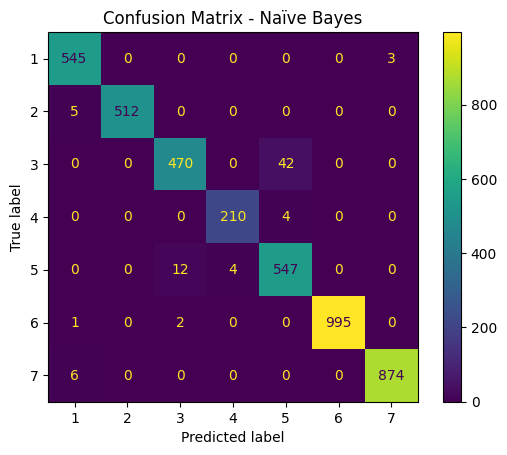

In [45]:
# Compute the confusion matrix
nbayes_conf_matr = confusion_matrix(testing_set_labels, nbayes_predictions)

# Displaying the confusion matrix
nbayes_conf_matr_display = ConfusionMatrixDisplay(
    confusion_matrix=nbayes_conf_matr, display_labels=np.unique(testing_set_labels)
)
nbayes_conf_matr_display.plot(cmap="viridis")
plt.title("Confusion Matrix - Naïve Bayes")
plt.show()

# Updating
confusion_matrices["Confusion Matrix - Naïve Bayes"] = nbayes_conf_matr_display

Compute the success rate

In [46]:
print(f"Success Rate: {(np.trace(nbayes_conf_matr) / np.sum(nbayes_conf_matr)):.4f}")

Success Rate: 0.9813


**2. Classification of the pixels of the hyperspectral image using the Bayes classifier**

Define a function to calculate the priori probabilities, mean vectors and covariance matrices of each label

In [47]:
def calculate_parameters(train_x, train_y, labels):
    """
    This function used to calculate the prior probabilities, the mean vectors
    and covariance matrices for each label

    :param train_x: The data of the training dataset
    :param train_y: The labels of the training dataset
    :param labels: Total labels
    :return: The prior probabilities, mean vectors, covariance matrices
    """

    # Setting up the dictionaries to store the prior probabilities,
    # the mean vectors and covariance matrices
    prior_prob, mean, covariance = {}, {}, {}

    # Iterating over the labels
    for label in labels:

        # Extracting x data
        x_data = train_x[train_y == label]

        # Getting the number of x data
        num_of_data = len(x_data)

        # Computing priori probabilities
        prior_prob[label] = num_of_data / len(train_x)

        # Computing mean
        mean[label] = np.sum(x_data, axis=0) / num_of_data

        # Computing covariance matrices
        difference = x_data - mean[label]
        covariance[label] = np.dot(difference.T, difference) / num_of_data

    return prior_prob, mean, covariance

Define a function for predicting labels

In [48]:
def classify_bayesian(x, prior_prob, mean, covariance, labels):
    """
    This function used to predict labels.

    :param x: The x value
    :param prior_prob: The priori probabilities
    :param mean: The mean vectors
    :param covariance: The covariance matrices
    :param labels: The labels
    :return: The final label
    """

    # List to keep the posterior values
    posteriors = []

    # Iterating over the labels
    for label in labels:

        # Calculating the pdf value
        pdf_value = multivariate_normal.pdf(x, mean=mean[label], cov=covariance[label])

        # Calculating the posterior value
        posterior = pdf_value * prior_prob[label]

        # Updating
        posteriors.append(posterior)

    # Getting the final label
    final_label = labels[np.argmax(posteriors)]

    return final_label

Perform 10-fold cross validation and compute the mean and standard deviation of the validation error

In [49]:
# Setting a list to store the error
validation_errors = []

# Setting the cross validation
cross_validation = KFold(n_splits=10, shuffle=True, random_state=42)

# Iterating over the folds
for train_index, val_index in cross_validation.split(training_set):

    # Splitting data into training and validation sets
    train_x, val_x = training_set[train_index], training_set[val_index]
    train_y, val_y = training_set_labels[train_index], training_set_labels[val_index]

    # Getting the unique labels
    labels = np.unique(train_y)

    # Calculating
    prior_prob, mean, covariance = calculate_parameters(train_x, train_y, labels)

    # Predicting
    predictions = np.array(
        [
            classify_bayesian(x_data, prior_prob, mean, covariance, labels)
            for x_data in val_x
        ]
    )

    # Getting the validation error
    validation_error = 1 - accuracy_score(val_y, predictions)

    # Storing
    validation_errors.append(validation_error)


print(f"Mean Validation Error: {np.mean(validation_errors):.4f}")
print(f"Standard Deviation of Validation Errors: {np.std(validation_errors):.4f}")

Mean Validation Error: 0.0330
Standard Deviation of Validation Errors: 0.0078


Train on the entire training dataset

In [50]:
# Getting the unique labels
labels = np.unique(training_set_labels)

# Calculating
prior_prob, mean, covariance = calculate_parameters(
    training_set, training_set_labels, labels
)

# Predicting
bayes_predictions = np.array(
    [
        classify_bayesian(x_data, prior_prob, mean, covariance, labels)
        for x_data in testing_set
    ]
)

bayes_predictions

array([6, 6, 6, ..., 2, 2, 2], dtype=uint8)

Compute and visualize the confusion matrix

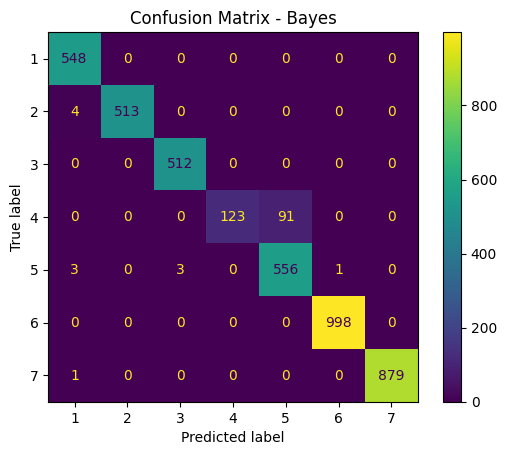

In [51]:
# Compute the confusion matrix
bayes_conf_matr = confusion_matrix(testing_set_labels, bayes_predictions)

# Displaying the confusion matrix
bayes_conf_matr_display = ConfusionMatrixDisplay(
    confusion_matrix=bayes_conf_matr, display_labels=np.unique(testing_set_labels)
)
bayes_conf_matr_display.plot(cmap="viridis")
plt.title("Confusion Matrix - Bayes")
plt.show()

# Updating
confusion_matrices["Confusion Matrix - Bayes"] = bayes_conf_matr_display

Compute the success rate

In [52]:
print(f"Success Rate: {(np.trace(bayes_conf_matr) / np.sum(bayes_conf_matr)):.4f}")

Success Rate: 0.9757


**3. Classification of the pixels of the hyperspectral image using the Minimum Euclidean Distance classifier**

Define a function for finding the centroids (mean vectors) of each class in the training dataset

In [53]:
def calculate_centroids(train_x, train_y, labels):
    """
    This function used to calculate the centroids (mean vector) for each class.

    :param train_x: The data of the training dataset
    :param train_y: The labels of the training dataset
    :param labels: Total labels
    :return: The mean vectors of the classes
    """

    # Initializing the dictionary to store the centroids
    centroids = {}

    # Iterating over the labels
    for label in labels:

        # Getting the centroids
        centroids[label] = train_x[train_y == label].mean(axis=0)

    return centroids

Define a function for predicting labels

In [54]:
def classify_min_euclidean(data, centroids):
    """
    This function used to predict labels for given data using minimum Euclidean distance.

    :param data: The data to predict labels for
    :centroids: The centroids of the classes
    :return: The predicted labels
    """

    # Initializing a list to store the predicted labels
    predictions = []

    # Iterating over the pixels
    for pixel in data:

        # Calculating all the distances from the centroids of the classes
        distances = {
            label: np.linalg.norm(pixel - centroid)
            for label, centroid in centroids.items()
        }

        # Getting the min distance and the corresponding label/class
        predictions.append(min(distances, key=distances.get))

    return np.array(predictions)

Perform 10-fold cross validation and compute the mean and standard deviation of the validation error

In [55]:
# Setting a list to store the error
validation_errors = []

# Setting the cross validation
cross_validation = KFold(n_splits=10, shuffle=True, random_state=42)

# Iterating over the folds
for train_index, val_index in cross_validation.split(training_set):

    # Splitting data into training and validation sets
    train_x, val_x = training_set[train_index], training_set[val_index]
    train_y, val_y = training_set_labels[train_index], training_set_labels[val_index]

    # Getting the unique labels
    labels = np.unique(train_y)

    # Calculating
    centroids = calculate_centroids(train_x, train_y, labels)

    # Predicting
    predictions = classify_min_euclidean(val_x, centroids)

    # Getting the validation error
    validation_error = 1 - accuracy_score(val_y, predictions)

    # Storing
    validation_errors.append(validation_error)


print(f"Mean Validation Error: {np.mean(validation_errors):.4f}")
print(f"Standard Deviation of Validation Errors: {np.std(validation_errors):.4f}")

Mean Validation Error: 0.0444
Standard Deviation of Validation Errors: 0.0048


Train on the entire training dataset

In [56]:
# Getting the unique labels
labels = np.unique(training_set_labels)

# Calculating
centroids = calculate_centroids(training_set, training_set_labels, labels)

# Predicting
min_euclidean_predictions = classify_min_euclidean(testing_set, centroids)

min_euclidean_predictions

array([6, 6, 6, ..., 2, 2, 2], dtype=uint8)

Compute and visualize the confusion matrix

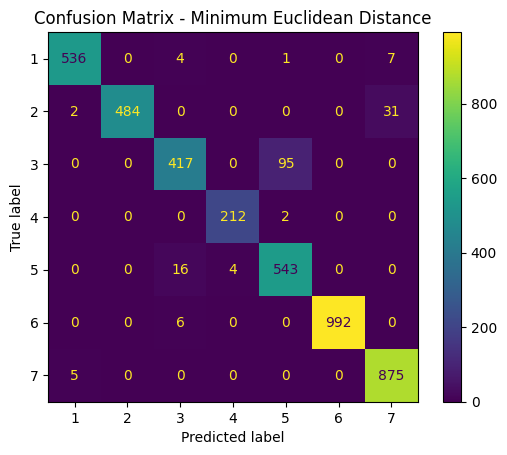

In [57]:
# Compute the confusion matrix
min_euclidean_conf_matr = confusion_matrix(
    testing_set_labels, min_euclidean_predictions
)

# Displaying the confusion matrix
min_euclidean_conf_matr_display = ConfusionMatrixDisplay(
    confusion_matrix=min_euclidean_conf_matr,
    display_labels=np.unique(testing_set_labels),
)
min_euclidean_conf_matr_display.plot(cmap="viridis")
plt.title("Confusion Matrix - Minimum Euclidean Distance")
plt.show()

# Updating
confusion_matrices["Confusion Matrix - Minimum Euclidean Distance"] = (
    min_euclidean_conf_matr_display
)

Compute the success rate

In [58]:
print(
    f"Success Rate: {(np.trace(min_euclidean_conf_matr) / np.sum(min_euclidean_conf_matr)):.4f}"
)

Success Rate: 0.9591


**4. Classification of the pixels of the hyperspectral image using the K-Nearest Neighbor classifier**

Apply hyperparameter tuning to the K parameter (n_neighbors) to find the best one that gives the smallest validation error. Through this procedure, cross-validation is performed

In [59]:
# Setting different values for the neighbors
neighbords_values = {"n_neighbors": [3, 5, 7, 9]}

# Setting up tunning process on the 'n_neighbors' parameter and cross validation for each value
grid_search = GridSearchCV(
    KNeighborsClassifier(), neighbords_values, cv=10, scoring="accuracy"
)

# Applying
grid_search.fit(training_set, training_set_labels)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9]}, scoring='accuracy')

Find the value of the parameter K that gives the best accuracy, i.e. the smallest validation error

In [60]:
# Getting the best value for the n_neighbors (k) parameter
best_k = grid_search.best_params_["n_neighbors"]

print("Best K value:", best_k)

Best K value: 3


Compute the mean and standard deviation of the validation error

In [61]:
# Accessing the index of the best k value
best_index = grid_search.best_index_

# Getting the mean and standard deviation of accuracy for the best k
mean_accuracy = grid_search.cv_results_["mean_test_score"][best_index]
std_accuracy = grid_search.cv_results_["std_test_score"][best_index]

# Getting the mean and standard deviation (which remains the same) of the validation error
mean_validation_error = 1 - mean_accuracy
std_validation_error = std_accuracy

print(f"Mean of Validation Errors: {mean_validation_error:.4f}")
print(f"Standard Deviation of Validation Errors: {std_validation_error:.4f}")

Mean of Validation Errors: 0.0089
Standard Deviation of Validation Errors: 0.0130


Train on the entire training dataset

In [62]:
# Training the classifier
knn_classifier = KNeighborsClassifier(n_neighbors=best_k)
knn_classifier.fit(training_set, training_set_labels)

# Predicting
knn_predictions = knn_classifier.predict(testing_set)

knn_predictions

array([6, 6, 6, ..., 2, 2, 2], dtype=uint8)

Compute and visualize the confusion matrix

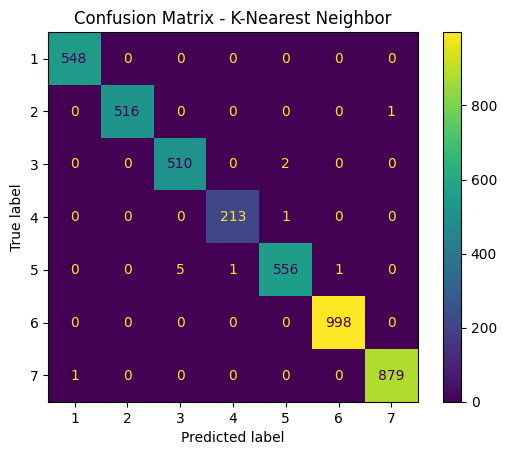

In [63]:
# Compute the confusion matrix
knn_conf_matr = confusion_matrix(testing_set_labels, knn_predictions)

# Displaying the confusion matrix
knn_conf_matr_display = ConfusionMatrixDisplay(
    confusion_matrix=knn_conf_matr, display_labels=np.unique(testing_set_labels)
)
knn_conf_matr_display.plot(cmap="viridis")
plt.title("Confusion Matrix - K-Nearest Neighbor")
plt.show()

# Updating
confusion_matrices["Confusion Matrix - K-Nearest Neighbor"] = knn_conf_matr_display

Compute the success rate

In [64]:
print(f"Success Rate: {(np.trace(knn_conf_matr) / np.sum(knn_conf_matr)):.4f}")

Success Rate: 0.9972


##### **Conclusion**

Display of all confusion matrices

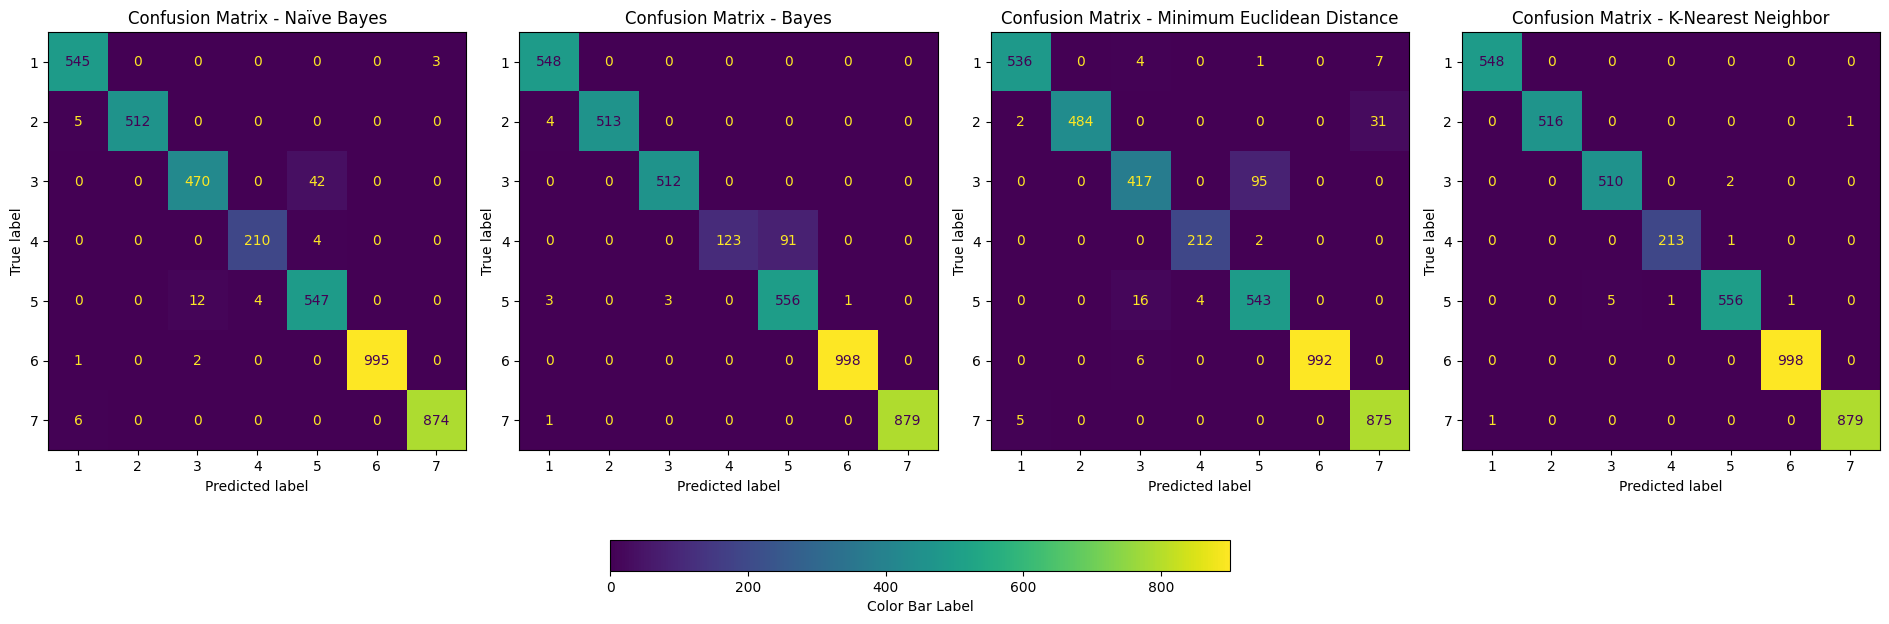

In [65]:
# Setting the figure and axes
fig, axes = plt.subplots(1, 4, figsize=(20, 10))

# Iterating over all the confusion matrices
for ax, (title, matrix) in zip(axes, confusion_matrices.items()):

    # Plotting the confuson matrix
    matrix.plot(cmap='viridis', ax=ax, colorbar=False)

    # Setting the title
    ax.set_title(f"{title}")

# Adding a shared color bar
cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=900)),
    ax=axes,
    location='bottom',
    shrink=0.4,
)

# Setting some parameters
cbar.set_ticks(np.arange(0, 900, 200))
cbar.set_label('Color Bar Label')

# Showing
plt.tight_layout(rect=[0.05, 0.3, 1, 1])
plt.show()

**1. Naïve Bayes**

- High accuracy in most classes, particularly Class 6 and Class 7, which have strong diagonal values.
- Most classes also demonstrate minimal misclassification.
- More misclassifications for the classes 3 and 5.
- In general, the Naïve Bayes classifier performs well overall but shows noticeable confusion in the classes 3 and 5.

**2. Bayes Classifier**

- Excellent classification for Class 6 and Class 7, with negligible misclassifications.
- Improved accuracy for Class 5 compared to Naïve Bayes.
- 91 misclassified instances for class 4 which is a significant increase compared to Naïve Bayes.
- While the Bayes classifier handles some classes better than Naïve Bayes, it struggles significantly with Class 4.

**3. Minimum Euclidean Distance**

- Good classification for Classes 6 and 7.
- More misclassifications for classes 2 and 3.
- The dependence on Euclidean distance makes this classifier less robust in handling high-dimensional feature spaces where classes may overlap or be non-linearly separable. It consistently shows lower accuracy compared to other classifiers.

**4. K-Nearest Neighbor**

- Highest accuracy across all classifiers, with nearly perfect diagonal entries for all classes.
- Significant improvement over all other classifiers for the classes 2, 3 and 4 with 1, 2 and 1 missclassifications respectively.
- The k-NN classifier effectively resolves overlapping class issues observed in other methods, particularly for classes 2, 3 and 4. Its performance suggests that the local neighborhood-based approach is well-suited for this dataset.

Summarise all the metrics calculated for each classifier

|Classifier|Mean of Validation Error|Standard Deviation of Validation Error|Success Rate|
|-------------------|-------------------|--------------|-------|
|Naïve Bayes|0.0184|0.0044|0.9813|
|Bayes|0.0330|0.0078|0.9757|
|Minimum Euclidean Distance|0.0444|0.0048|0.9591|
|K-Nearest Neighbor|0.0089|0.0130|0.9972|

**1. Success Rate**

- The K-Nearest Neighbor classifier achieved the highest success rate at 99.72%, demonstrating superior classification performance compared to other methods.
- The Naïve Bayes classifier follows closely with a success rate of 98.13%.
- The Bayes classifier and Minimum Euclidean Distance showed relatively lower success rates at 97.57% and 95.91%, respectively.

**2. Validation Error Analysis**

- The KNN classifier also has the lowest mean validation error of 0.0089, which indicates its strong ability to generalize to unseen data.
- The Naïve Bayes classifier has the second lowest mean validation error at 0.0184, closely followed by the Bayes classifier at 0.0330.
- The Minimum Euclidean Distance classifier has the highest mean validation error, 0.0444, indicating relatively weaker generalization performance compared to other methods.

**3. Standard Deviation Analysis:**

- The Naïve Bayes classifier demonstrates the most stable performance across validation sets, with the smallest standard deviation of validation error at 0.0044.
- The Bayes classifier and Minimum Euclidean Distance have slightly higher standard deviations at 0.0078 and 0.0048, respectively.
- Interestingly, despite the KNN classifier's high accuracy, its standard deviation is relatively larger at 0.0130, suggesting that it may exhibit more variability in performance across different validation splits.

### **Part 3**

A possible correlation between the two tasks is that both try to separate classes in one case by applying regression models and in the other case by applying classification models. It would make sense to use the operational set which we have not yet used to see how both types of models perform. Specifically, we will use one model from each task that achieves the best separation, where in regression as we saw, it is LS with both constraints applied and in classification it is the K-NN algorithm with the K parameter equal to 3. Through this we will see which of the two best performs the underlying task, which is class/label separation.

In [70]:
# Getting the operational set labels
operational_set_labels = (np.reshape(hsi_labels["operational_set"], (120, 220))).T

# Getting the shape of operational_set_labels
operational_set_labels_shape = operational_set_labels.shape


# Reshaping
operational_set_labels = operational_set_labels.reshape(
    operational_set_labels_shape[0] * operational_set_labels_shape[1]
)

As before we will keep only the pixels with nonzero labels

In [71]:
# Filtering
hsi_non_zero_2 = hsi[operational_set_labels != 0]

# Getting the total pixels
operational_total_pixels = hsi_non_zero_2.shape[0]

# Getting the mulptiplication of the two first dimensions
operational_two_dim = operational_set_labels_shape[0] * operational_set_labels_shape[1]

Compute the abundance maps of the endmembers based on the LS with both constraints applied

In [72]:
# Computing the abundance maps and the reconstruction error
abundances_operational, reconstruction_error_operational = unmix_ls_both_constraints(
    hsi_non_zero_2,
    endmembers,
    initial_two_dim,
    operational_total_pixels,
    operational_set_labels,
)

Visualize the abundance maps

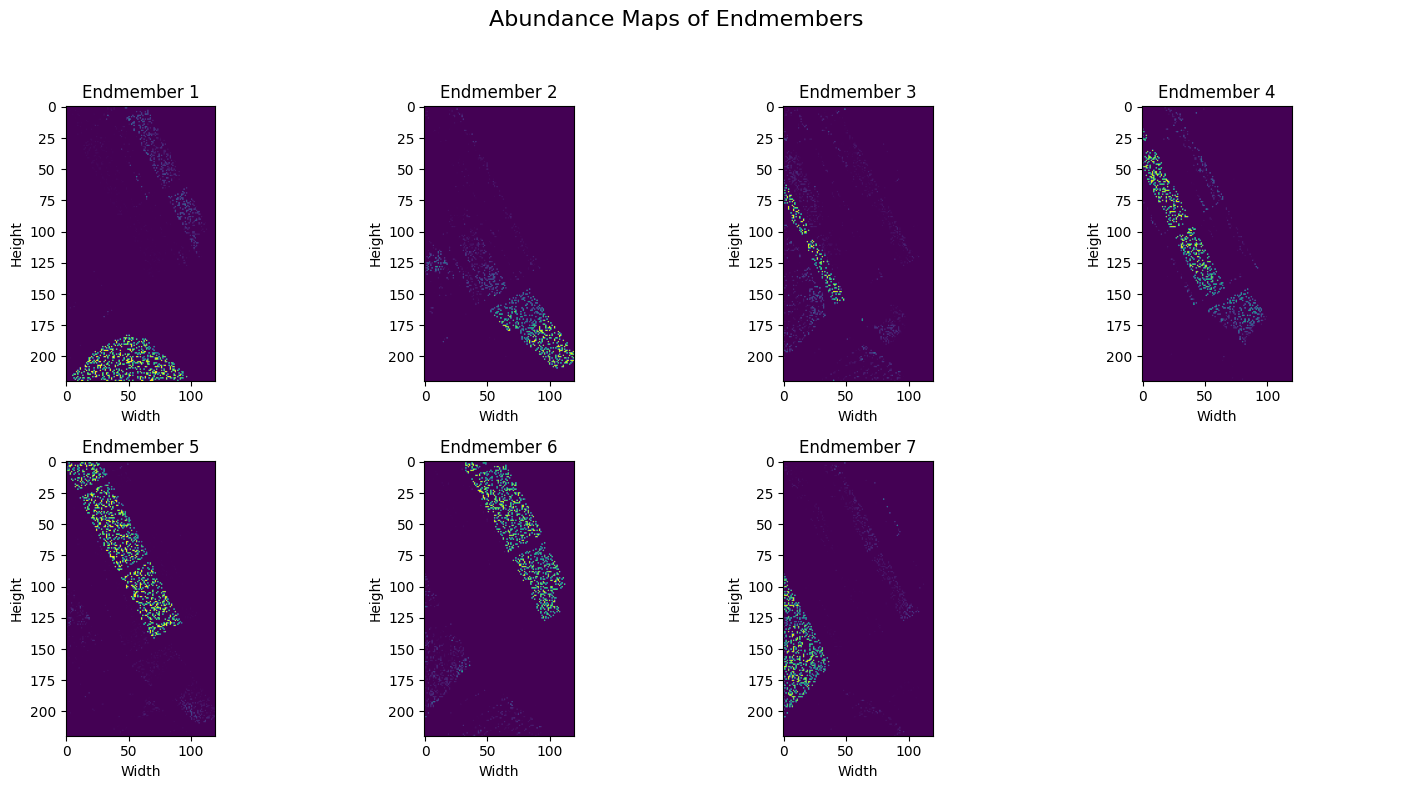

In [74]:
# Visualizing the abundance maps
visualize_abundance_maps(abundances_operational, hsi_shape[0], hsi_shape[1])

Predict the labels using the already trained K-NN model with K = 3

In [75]:
# Predicting
knn_predictions_operational = knn_classifier.predict(hsi_non_zero_2)

Process the predictions and show the final abundance vectors of the labels

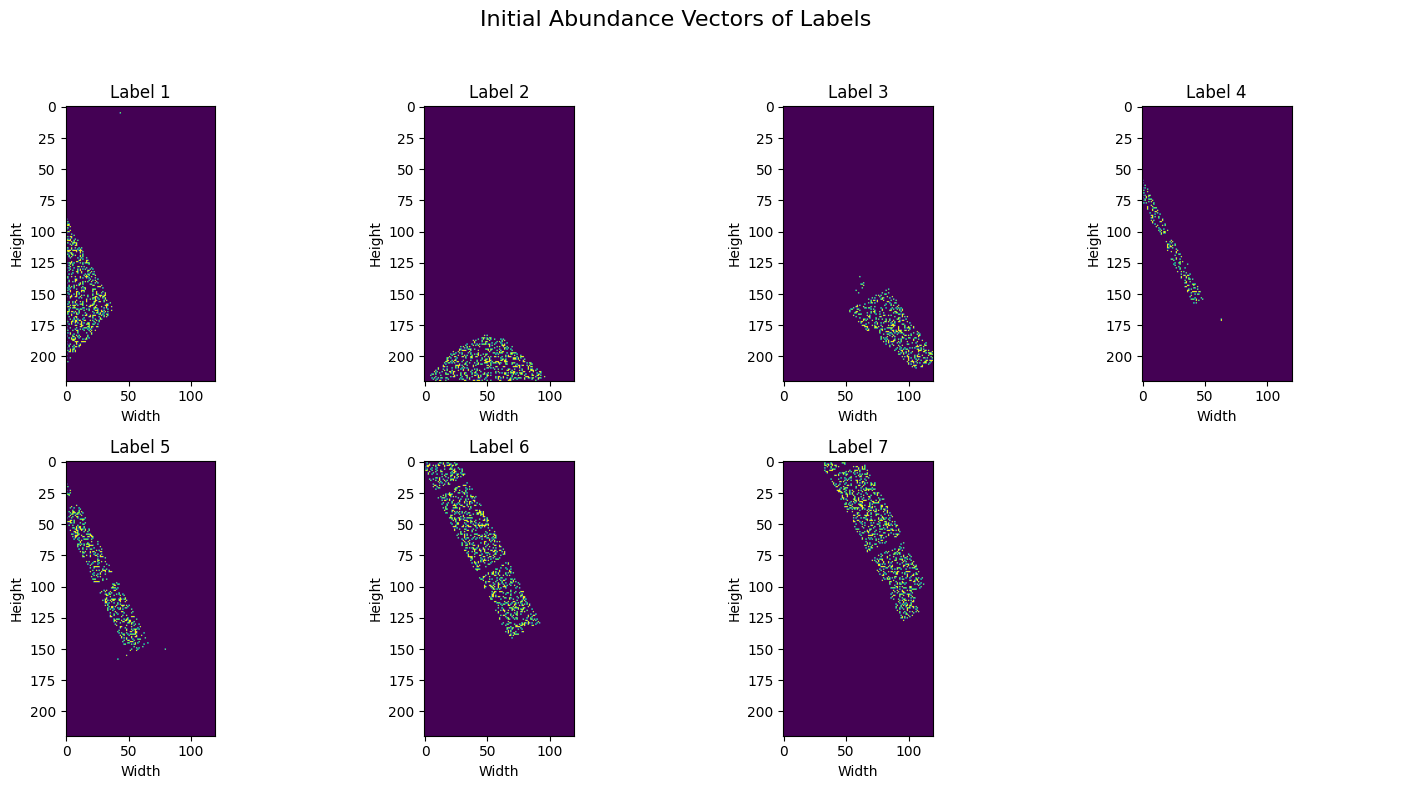

In [76]:
# Initializing a matrix with the final labels of all pixels
operational_predictions_matrix = np.zeros((operational_two_dim))

# Iterating over the predictions
for index, prediction in enumerate(knn_predictions_operational):

    # Mapping the index
    initial_index = np.where(operational_set_labels != 0)[0][index]

    # Updating
    operational_predictions_matrix[initial_index] = prediction

# Getting the abundance vectors of the labels
abundance_vectors_operational = find_abundance_vectors(
    operational_predictions_matrix, operational_two_dim
)

visualize_abundance_vectors(abundance_vectors_operational)

In the above figures we can observe that the K-NN classification model is better at separating labels than the regression model, which is a logical conclusion since classification algorithms are designed for this purpose and K-NN has success rate/accuracy very to close to 100% (99.72%). We understand, that in some cases like here regression model can be used for entity separation but it cannot reach the levels of precision as a pure classification algorithm